## Import all required tools

In [1]:
import ixmp
import message_ix
import numpy as np
import pandas as pd
import yaml

import matplotlib.pyplot as plt

from collections.abc import Mapping
from itertools import repeat
from message_ix.models import MESSAGE_ITEMS
from message_ix.utils import make_df
from message_ix.tools.add_dac import add_tech
from message_ix.tools.add_dac import get_report

%matplotlib inline


mp = ixmp.Platform()


<IPython.core.display.Javascript object>

C:\Users\pratama\Documents\GitHub\MESSAGEix\message_ix\message_ix\reporting\__init__.py:98: FutureWarning: Importing from genno.computations will be deprecated in a future version; use genno.operator instead.
  ("tom:nl-t-yv-ya", (genno.computations.add, "fom:nl-t-yv-ya", "vom:nl-t-yv-ya")),


In [2]:
def plotvars(scenario):
    # CO2 Emission
    emiss = scenario.var("EMISS")
    emiss = emiss.loc[(emiss['type_tec'] == 'all') & 
                      (emiss['node'] == 'World') & 
                      (emiss['emission'] == 'TCE')]
    emiss_plot = emiss[['year','lvl']].set_index(['year']).div(1000)

    # CO2 Removal
    removal = scenario.var("EMISS")
    removal = removal.loc[(removal['type_tec'] == 'all') & 
                          (removal['node'] == 'World') & 
                          (removal['emission'] == 'CO2_storage')]
    removal_plot = removal[['year','lvl']].set_index(['year']).div(1000)

    # CO2 Prices
    CO2Price = (scenario.var("PRICE_EMISSION")
                .loc[scenario.var("PRICE_EMISSION")['type_emission'] == 'TCE'][['year','lvl']]
                .set_index(['year'])).div(1000)
    
    
    plt.figure(figsize=(4,4))
    # Plottings
    plt.plot(emiss_plot, label='CO2 Emission')
    plt.plot(removal_plot, label='CO2 Removal')
    plt.plot(CO2Price, label='CO2 Price')
    
    plt.ylim(-25,25)
    plt.ylabel("thousands of var unit")
    
    plt.legend()
    plt.show()

## Run SSP5_dev DAC baseline scenario
**Clone and create SSP5_dev DAC baseline scenario**

In [3]:
# this is to import scenario from data base and clone to local
base = message_ix.Scenario(mp, model='SSP_dev_SSP5_v0.1', scenario="baseline_v0.13")
base_scen = base.clone(
    "SSP_dev_SSP5_v0.1_dac",
    "baseline_v0.13",
    "SSP5_dev for DAC",
    keep_solution=False, 
)
base_scen.check_out()

year_df = base_scen.vintage_and_active_years()
vintage_years, act_years = year_df["year_vtg"], year_df["year_act"]
model_horizon = base_scen.set("year")


In [4]:
base_scen.commit(comment="SSP5_dev baseline with DAC scenario")
base_scen.set_as_default()

In [5]:
base_scen.solve(solve_options={'scaind': '1'}) # solve_options={'barcrossalg': '2','scaind':'1'}
base_scen.var("OBJ")["lvl"]

3100161.75

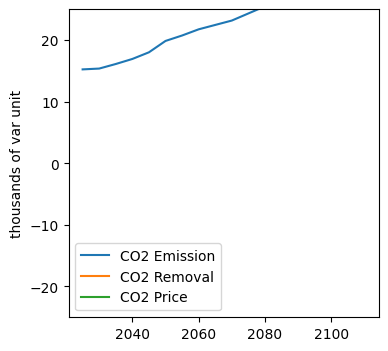

In [6]:
plotvars(base_scen)

## Run SSP5_dev 1000f scenario
**Clone and create SSP5_dev 1000f scenario**

In [7]:
# this is to import scenario from data base and clone to local
scen = base_scen.clone(
    "SSP_dev_SSP5_v0.1_dac",
    "1000f_v0.13",
    "SSP5_dev with 1000f budget",
    keep_solution=False, 
)
scen.check_out()

year_df = scen.vintage_and_active_years()
vintage_years, act_years = year_df["year_vtg"], year_df["year_act"]
model_horizon = scen.set("year")


In [8]:
# add emission bound
scen.add_par('bound_emission', ['World', 'TCE', 'all', 'cumulative'], value=4046, unit="tC")


In [9]:
scen.commit(comment="SSP5_dev 1000f without DAC scenario")
scen.set_as_default()

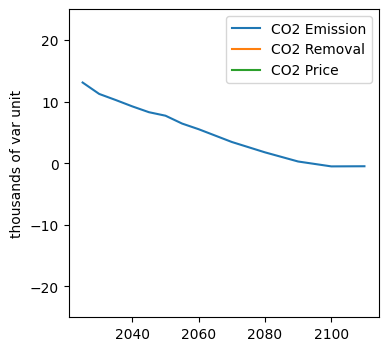

In [10]:
scen.solve(solve_options={'scaind': '1'}) # solve_options={'barcrossalg': '2','scaind':'1'}
scen.var("OBJ")["lvl"]
plotvars(scen)

## Run SSP5_dev 1000f with DAC scenario
**Clone and create SSP5_dev 1000f with DAC scenario**

In [11]:
# this is to import scenario from data base and clone to local
dacscen = scen.clone(
    "SSP_dev_SSP5_v0.1_dac",
    "1000f_v0.13_dac",
    "SSP5_dev with 1000f budget and dac",
    keep_solution=False, 
)
dacscen.check_out()

year_df = dacscen.vintage_and_active_years()
vintage_years, act_years = year_df["year_vtg"], year_df["year_act"]
model_horizon = scen.set("year")

In [12]:
# add daccs
filepath = 'C:/Users/pratama/Documents/GitHub/MESSAGEix/message_ix/tutorial/dac_scenarios/data/tech_data_ssp5dev.yaml'
add_tech(dacscen,filepath=filepath)

In [13]:
# removing some parameters
pars2remove = ['emission_factor','capacity_factor','var_cost','output']
for par in pars2remove:
    df = dacscen.par(par,{'technology':'dacco2_tr_dis'})
    df= df.loc[df['year_vtg'] != df['year_act']]
    dacscen.remove_par(par, df)

# removing excess year_act
pars2remove = ['capacity_factor','fix_cost','input']
techs = ['dac_2', 'dac_1', 'dac_3', 'dac_4', 'dac_5']
for par in pars2remove:
    df = dacscen.par(par,{'technology':techs})
    df = df.loc[df['year_act'] > df['year_vtg'].add(30)]
    dacscen.remove_par(par, df)

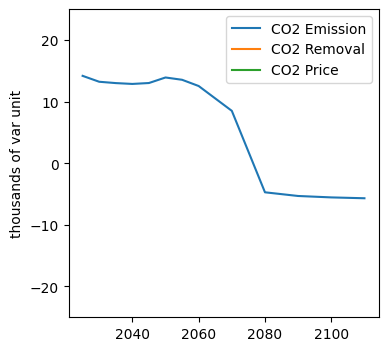

In [14]:
# add emission bound
dacscen.commit(comment="SSP5_dev 1000f with DAC scenario")
dacscen.set_as_default()

dacscen.solve(solve_options={'scaind': '1'}) # solve_options={'barcrossalg': '2','scaind':'1'}
dacscen.var("OBJ")["lvl"]
plotvars(dacscen)

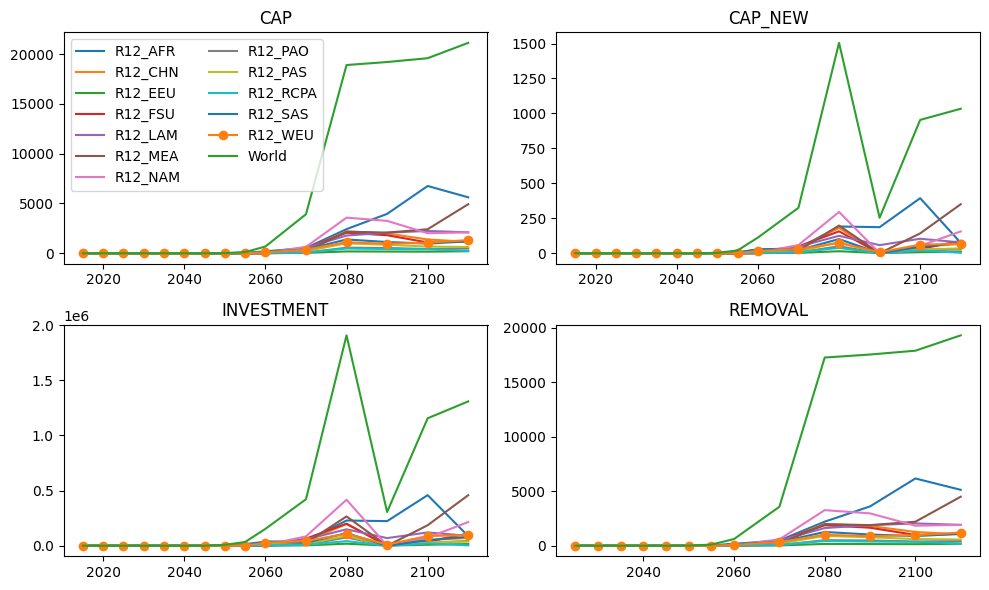

In [15]:
# Get Report
scenario = message_ix.Scenario(mp, model="SSP_dev_SSP5_v0.1_dac", scenario="1000f_v0.13_dac")
scenariotec = ['dac_1','dac_2','dac_3','dac_4','dac_5']

scenario_report = get_report(scenario,scenariotec)


## Close connection

In [16]:
mp.close_db()